In [1]:
import logging
from urllib.parse import urlparse
import time
import matplotlib.pyplot as plt
from gql import Client, gql
from gql.transport.requests import RequestsHTTPTransport
import requests

In [2]:
class GraphQLClient(object):
    CONNECT_TIMEOUT = 15  # [sec]
    RETRY_DELAY = 10  # [sec]
    MAX_RETRIES = 3  # [-]

    class Decorators(object):
        @staticmethod
        def autoConnectingClient(wrappedMethod):
            def wrapper(obj, *args, **kwargs):
                for retry in range(GraphQLClient.MAX_RETRIES):
                    try:
                        return wrappedMethod(obj, *args, **kwargs)
                    except Exception:
                        pass
                    try:
                        obj._logger.warning(
                                '(Re)connecting to GraphQL service.'
                        )
                        obj.reconnect()
                    except ConnectionRefusedError:
                        obj._logger.warn(
                            'Connection refused. Retry in 10s.'.format(
                                GraphQLClient.RETRY_DELAY
                            )
                        )
                        time.sleep(GraphQLClient.RETRY_DELAY)
                else:  # So the exception is exposed.
                    obj.reconnect()
                    return wrappedMethod(obj, *args, **kwargs)
            return wrapper

    def __init__(self, serverUrl):
        self._logger = logging.getLogger(self.__class__.__name__)
        self.connect(
            serverUrl.geturl()
        )

    def __enter__(self):
        self.connect(
            serverUrl.geturl()
        )
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        self._client = None

    def connect(self, url):
        host = url.split('//')[1].split('/')[0]
        request = requests.get(url,
                               headers={
                                       'Host': str(host),
                                       'Accept': 'text/html',
                                       }
                               )
        request.raise_for_status()
        csrf = request.cookies['csrftoken']
        self._client = Client(
                transport=RequestsHTTPTransport(url=url,
                                                cookies={"csrftoken": csrf},
                                                headers={'x-csrftoken':  csrf}
                                                ),
                fetch_schema_from_transport=True
                )

    def disconnect(self):
        self._client = None

    def reconnect(self):
        self.disconnect()
        self.connect(
            serverUrl.geturl()
        )

    @Decorators.autoConnectingClient
    def execute_query(self, querytext):
        query = gql(querytext)
        return self._client.execute(query)

In [3]:
class DataAcquisition(object):
    LOGGER = logging.getLogger('DataAcquisition')

    @staticmethod
    def get_sensor_data(serverUrl, macId, starttime, endtime, limit, axis):
        with GraphQLClient(serverUrl) as client:
            querytext = '''
            { deviceManager { device(macId:"''' + macId + '''") {
                __typename
                ... on GrapheneVibrationCombo {vibrationTimestampHistory(start:"''' + str(starttime) + '''", end:"''' + str(endtime) + '''", limit:''' + str(limit) + ''', axis:"''' + axis + '''")}
            }}}
            '''
            #print('1st one : ' + querytext)
            result = client.execute_query(querytext)
            times = \
                result['deviceManager']['device']['vibrationTimestampHistory']
            dates, values, franges = ([], [], [])
            for t in times:
                result = DataAcquisition.get_sensor_measurement(
                        client,
                        macId,
                        t
                )
                dates.append(t)
                deviceData = result['deviceManager']['device']
                values.append(
                        deviceData['vibrationArray']['rawSamples']
                )
                franges.append(
                        deviceData['vibrationArray']['formatRange']
                )
            return (values, dates, franges)
        
    @staticmethod
    def get_sensor_measurement(client, macId, isoDate):
        querytext = '''
        { deviceManager { device(macId:"''' + macId + '''") {
        __typename
        ... on GrapheneVibrationCombo { vibrationArray(isoDate: "''' + isoDate + '''") {
        numSamples rawSamples sampleRate formatRange axis }}
        }}}
        '''
        #print('2nd one : '+querytext)
        return client.execute_query(querytext)


In [4]:
logging.basicConfig(level=logging.INFO)
logging.getLogger("graphql").setLevel(logging.WARNING)

serverIP = "192.168.x.x"
serverUrl = urlparse('http://{:s}:8000/graphql'.format(serverIP))


macId = '2e:ce:e8:fd'

starttime = "2020-07-12"
endtime = "2020-07-13"

limit = 30  # limit limits the number of returned measurements
axis = 'X'  # axis allows to select data from only 1 or multiple axes

# acquire history data
(values, dates, franges) = DataAcquisition.get_sensor_data(
    serverUrl=serverUrl,
    macId=macId,
    starttime=starttime,
    endtime=endtime,
    limit=limit,
    axis=axis
)


#print(values)



1st one : 
            { deviceManager { device(macId:"29:9c:fe:16") {
                __typename
                ... on GrapheneVibrationCombo {vibrationTimestampHistory(start:"2020-07-12", end:"2020-07-13", limit:30, axis:"X")}
            }}}
            
2nd one : 
        { deviceManager { device(macId:"29:9c:fe:16") {
        __typename
        ... on GrapheneVibrationCombo { vibrationArray(isoDate: "2020-07-12T00:28:44.405000+00:00") {
        numSamples rawSamples sampleRate formatRange axis }}
        }}}
        
2nd one : 
        { deviceManager { device(macId:"29:9c:fe:16") {
        __typename
        ... on GrapheneVibrationCombo { vibrationArray(isoDate: "2020-07-12T01:06:22.237000+00:00") {
        numSamples rawSamples sampleRate formatRange axis }}
        }}}
        
2nd one : 
        { deviceManager { device(macId:"29:9c:fe:16") {
        __typename
        ... on GrapheneVibrationCombo { vibrationArray(isoDate: "2020-07-12T01:53:55.464000+00:00") {
        numSa

print(franges)

for i in range(len(franges)):
    values[i] = [d/512.0*franges[i] for d in values[i]]
    plt.figure()
    plt.plot(values[i])
    plt.title(str(dates[i]))
    plt.savefig("image_"+str(i)+".png")
    plt.close()

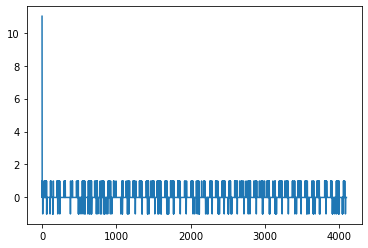

In [5]:
plt.plot(values[0])

### Trying to export data into  csv files

In [31]:
serverIP = "192.168.x.x"
serverUrl = urlparse('http://{:s}:8000/graphql'.format(serverIP))


macId = ['22:f0:a9:04','29:9c:fe:16','2a:09:bc:17','2e:ce:e8:fd','44:f4:50:cd','4c:92:10:8c','61:3e:af:33','7c:92:dd:85','84:e1:93:bd','88:86:af:12','8a:18:56:08','ee:10:05:23','be:31:bf:c2','f4:9f:07:04']
#macId = ['22:f0:a9:04']
starttime = "2020-07-12"
endtime = "2020-07-13"
limit = 20

limit = 30  # limit limits the number of returned measurements
axis_list = ['X','Y','Z']  # axis allows to select data from only 1 or multiple axes
                        
for Id in macId:
    for axis in axis_list:
        # acquire history data
        (values, dates, franges) = DataAcquisition.get_sensor_data(serverUrl=serverUrl,macId=Id,starttime=starttime,endtime=endtime,limit=limit,axis=axis)
        with open(starttime+'_'+Id.replace(":","")+"_TEST_LOOP_RAW_DATA"+'.csv','a') as f:
            for i in range(len(franges)):
                values[i] = [d/512.0*franges[i] for d in values[i]]
                line = str(dates[i])+','+axis+',' 
                for val in range(len(values[i])):
                    #print(val)
                    line+=str(values[i][val])+','
                line+='\n'
                f.write(line)
            line=""

KeyError: 'vibrationTimestampHistory'